# Bayesian Experimental Design for model selection

Script used to perform a 4 step optimisation with a Matern Kernel with nu=0.5. To change the Kernel, this needs to be done in the source code of the package used since there is no apparent parameter in the functions to modulate it. The acquisition function has been changed to EI, where xi=1e-1 to decrease the smoothness of the kernel

   ............................................................................................................................................................................................................................................

### Import Required libraries

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import seaborn as sns
from numba import jit
import gaussianprocess as gp
from fitderiv import fitderiv
import genutils as gu
import datetime
from bayes_opt import BayesianOptimization
from bayes_opt.observer import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs
import pickle

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import math


### Model 1 Functions (ODEs, Steady State and Event based representation)
* Lugagne et. al. Model

In [2]:
@jit
def model1(y,t,p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    
    # Parameters
    k_in_IPTG = p[0]
    k_out_IPTG = p[1]
    k_in_aTc = p[2]
    k_out_aTc = p[3]
    k_L_pm0 = p[4]
    k_L_pm = p[5]
    theta_T = p[6]
    theta_aTc = p[7]
    n_aTc = p[8]
    n_T = p[9];
    k_T_pm0 = p[10]
    k_T_pm = p[11]
    theta_L = p[12]
    theta_IPTG = p[13]
    n_IPTG = p[14]
    n_L = p[15]
    
    # ODEs
    dInd_dt = np.empty(4).tolist()
    
    if u_IPTG > y[0]:
        dInd_dt[0]=k_in_IPTG*(u_IPTG-y[0])
    else:
        dInd_dt[0]=k_out_IPTG*(u_IPTG-y[0])
    
    if u_aTc > y[2]:
        dInd_dt[1]=k_in_aTc*(u_aTc-y[1])
    else:
        dInd_dt[1]=k_out_aTc*(u_aTc-y[1])
    
    dInd_dt[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+(y[3]/theta_T*1/(1+(y[1]/theta_aTc)**n_aTc))**n_T))))-0.0165*y[2];
    dInd_dt[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+(y[2]/theta_L*1/(1+(y[0]/theta_IPTG)**n_IPTG))**n_L))))-0.0165*y[3];
    
    # Results
    return dInd_dt

def SteadyState1(p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    preRFP = I[2]
    preGFP = I[3]
    
    # Parameters
    k_in_IPTG = p[0]
    k_out_IPTG = p[1]
    k_in_aTc = p[2]
    k_out_aTc = p[3]
    k_L_pm0 = p[4]
    k_L_pm = p[5]
    theta_T = p[6]
    theta_aTc = p[7]
    n_aTc = p[8]
    n_T = p[9];
    k_T_pm0 = p[10]
    k_T_pm = p[11]
    theta_L = p[12]
    theta_IPTG = p[13]
    n_IPTG = p[14]
    n_L = p[15]
    
    # ODEs steady state equations
    alpha = np.empty(2)
    alpha[0] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+((preGFP/theta_T)*1/(1+(u_aTc/theta_aTc)**n_aTc))**n_T))))/0.0165
    alpha[1] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+((preRFP/theta_L)*1/(1+(u_IPTG/theta_IPTG)**n_IPTG))**n_L))))/0.0165
    
    # Results
    return alpha


def solve_coupled_ode1(ts, p, sp, inputs, ivss, pre):
    maxtime = len(ts);
    Nsp = len(sp);
    Nevents = len(sp)-1;
    Neq = 4;
    p = p
    
    final = np.zeros((maxtime,Neq))
    Y0 = np.empty(4)
    
    y_al = SteadyState1(p,ivss) # Calculation of initial guesses for steady state
    Y0[0] = pre[0]
    Y0[1] = pre[1]
    Y0[2] = y_al[0]
    Y0[3] = y_al[1]
    ssv = odeint(model1,Y0,np.linspace(0,24*60,(24*60)+1),args=(p,pre), rtol=1e-9,atol=1e-9, tcrit=np.array(range(0,24*60+1)))
    
    y0 = ssv[24*60,:]
    
    initialV = y0
    i = 0
    
    for q in range(0,Nevents):
        
        lts = len(ts[(sp[q]+1):sp[q+1]+1])  # General way to define the number of elements in each event series
        Tevent = ts[(sp[q]):sp[q+1]+1]  # General way to extract the times of each event
        I = inputs[i:(i+2)]
        
        if q == 0:
            
            part1 = odeint(model1,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))#, full_output =1)
            
        else:
            
            part1 = odeint(model1,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))
        
        initialV = part1[lts]
        i=i+2;
        
        for d in range((sp[q]),(sp[q]+lts+1)):
            
            final[d,:] = part1[d-sp[q]]

    return(final)



### Model 2 Functions (ODEs, Steady State and Event based representation)
* Intermediate Model (Single rate, no degradation)

In [3]:
@jit
def model2(y,t,p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs
    dInd_dt = np.empty(4).tolist()
    dInd_dt[0] = k_IPTG*(u_IPTG-y[0]);
    dInd_dt[1] = k_aTc*(u_aTc-y[1]);
    dInd_dt[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+(y[3]/theta_T*1/(1+(y[1]/theta_aTc)**n_aTc))**n_T))))-0.0165*y[2];
    dInd_dt[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+(y[2]/theta_L*1/(1+(y[0]/theta_IPTG)**n_IPTG))**n_L))))-0.0165*y[3];
    
    # Results
    return dInd_dt

def SteadyState2(p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    preRFP = I[2]
    preGFP = I[3]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs steady state equations
    alpha = np.empty(2)
    alpha[0] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+((preGFP/theta_T)*1/(1+(u_aTc/theta_aTc)**n_aTc))**n_T))))/0.0165
    alpha[1] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+((preRFP/theta_L)*1/(1+(u_IPTG/theta_IPTG)**n_IPTG))**n_L))))/0.0165
    
    # Results
    return alpha


def solve_coupled_ode2(ts, p, sp, inputs, ivss, pre):
    maxtime = len(ts);
    Nsp = len(sp);
    Nevents = len(sp)-1;
    Neq = 4;
    p = p
    
    final = np.zeros((maxtime,Neq))
    Y0 = np.empty(4)
    
    y_al = SteadyState2(p,ivss) # Calculation of initial guesses for steady state
    Y0[0] = pre[0]
    Y0[1] = pre[1]
    Y0[2] = y_al[0]
    Y0[3] = y_al[1]
    ssv = odeint(model2,Y0,np.linspace(0,24*60,(24*60)+1),args=(p,pre), rtol=1e-9,atol=1e-9, tcrit=np.array(range(0,24*60+1)))
    
    y0 = ssv[24*60,:]
    
    initialV = y0
    i = 0
    
    for q in range(0,Nevents):
        
        lts = len(ts[(sp[q]+1):sp[q+1]+1])  # General way to define the number of elements in each event series
        Tevent = ts[(sp[q]):sp[q+1]+1]  # General way to extract the times of each event
        I = inputs[i:(i+2)]
        
        if q == 0:
            
            part1 = odeint(model2,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))#, full_output =1)
            
        else:
            
            part1 = odeint(model2,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))
        
        initialV = part1[lts]
        i=i+2;
        
        for d in range((sp[q]),(sp[q]+lts+1)):
            
            final[d,:] = part1[d-sp[q]]

    return(final)



### Model 3 Functions (ODEs, Steady State and Event based representation)
* Lucia's Model

In [4]:
@jit
def model3(y,t,p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs
    dInd_dt = np.empty(4).tolist()
    dInd_dt[0] = k_IPTG*(u_IPTG-y[0])-0.0165*y[0];
    dInd_dt[1] = k_aTc*(u_aTc-y[1])-0.0165*y[1];
    dInd_dt[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+(y[3]/theta_T*1/(1+(y[1]/theta_aTc)**n_aTc))**n_T))))-0.0165*y[2];
    dInd_dt[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+(y[2]/theta_L*1/(1+(y[0]/theta_IPTG)**n_IPTG))**n_L))))-0.0165*y[3];
    
    # Results
    return dInd_dt

def SteadyState3(p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    preRFP = I[2]
    preGFP = I[3]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs steady state equations
    alpha = np.empty(4)
    alpha[0] = (k_IPTG*u_IPTG)/(k_IPTG+0.0165)
    alpha[1] = (k_aTc*u_aTc)/(k_aTc+0.0165)
    alpha[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+((preGFP/theta_T)*1/(1+(alpha[1]/theta_aTc)**n_aTc))**n_T))))/0.0165
    alpha[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+((preRFP/theta_L)*1/(1+(alpha[0]/theta_IPTG)**n_IPTG))**n_L))))/0.0165
    
    # Results
    return alpha


def solve_coupled_ode3(ts, p, sp, inputs, ivss, pre):
    maxtime = len(ts);
    Nsp = len(sp);
    Nevents = len(sp)-1;
    Neq = 4;
    p = p
    
    final = np.zeros((maxtime,Neq))
    
    y_al = SteadyState3(p,ivss) # Calculation of initial guesses for steady state
    
    ssv = odeint(model3,y_al,np.linspace(0,24*60,(24*60)+1),args=(p,pre), rtol=1e-9,atol=1e-9, tcrit=np.array(range(0,24*60+1)))
    
    y0 = ssv[24*60,:]
    
    initialV = y0
    i = 0
    
    for q in range(0,Nevents):
        
        lts = len(ts[(sp[q]+1):sp[q+1]+1])  # General way to define the number of elements in each event series
        Tevent = ts[(sp[q]):sp[q+1]+1]  # General way to extract the times of each event
        I = inputs[i:(i+2)]
        
        if q == 0:
            
            part1 = odeint(model3,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))#, full_output =1)
            
        else:
            
            part1 = odeint(model3,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))
        
        initialV = part1[lts]
        i=i+2;
        
        for d in range((sp[q]),(sp[q]+lts+1)):
            
            final[d,:] = part1[d-sp[q]]
        
        
        
    
    return(final)

### Functions to simulate the 3 models for all parameter draws

In [5]:
def solveALL (ts, pD, sp, inputs, ivss, pre, model):
    
    AllSol = np.empty((len(ts),len(pD[:,1])*2))
    AllSolTest = np.empty(((round(len(ts)/5)+1),len(pD[:,1])*2))
    for drawInd in range(0,len(pD[:,1])):
        
        p = pD[drawInd,:]
        if model == 'M1':
            temp = solve_coupled_ode1(ts, p, sp, inputs, ivss, pre)
        elif model == 'M2':
            temp = solve_coupled_ode2(ts, p, sp, inputs, ivss, pre)
        elif model == 'M3':
            temp = solve_coupled_ode3(ts, p, sp, inputs, ivss, pre)
        else:
            print('Please, select a correct model as M1, M2 or M3 for the desired one')

        AllSolTest[:,drawInd] = temp[:,2][::5]
        AllSolTest[:,drawInd+(len(pD[:,1]))] = temp[:,3][::5]

    return(AllSolTest)
    

### Example:

In [6]:
ivss = [1,1e-7,1363.193,28.510]
pre = [1,1e-7]
inputs = np.empty(18) # What needs to be optimised    --> example: [1e-7,100,1,1e-7]*4+[1e-7,100]
evnT = [int(i) for i in list(np.linspace(0,(24*60),10))]
t = np.linspace(0,(24*60),(24*60)+1)
pM3 = np.asarray(pd.read_csv("ParametersCSV/draws_ALL_Model3.stan.csv"))

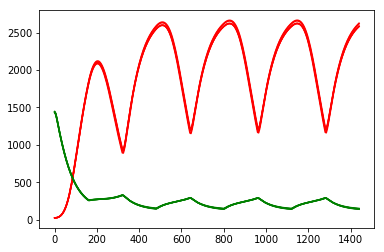

In [7]:
p = pM3[0:5,:]
test = solveALL(t,p,evnT,[1e-7,100,1,1e-7]*4+[1e-7,100],ivss,pre, 'M3')
plt.figure()
plt.plot(t[::5], test[:,0:5], 'r')
plt.plot(t[::5], test[:,5:10], 'g')
plt.show()

### Bhattacharyya distance function:

In [7]:

def BhattacharyyaDist (mu1, mu2, sd1, sd2):
    E = (sd1+sd2)/2
    Em1 = np.linalg.inv(E)
    dE = abs(np.linalg.det(E))

    t1 = np.matrix.transpose((np.matrix.transpose(np.matrix(mu1))-np.matrix.transpose(np.matrix(mu2))))
    t2 = np.matrix.transpose(np.matrix(mu1))-np.matrix.transpose(np.matrix(mu2))
    
    ft = (1/8)*t1*Em1*t2
    st = dE/np.sqrt(abs(np.linalg.det(sd1))*abs(np.linalg.det(sd2)))
    
    bhd = ft+0.5*np.log(st)
    
    return(float(bhd))



In [8]:
# Extract time points from flat regions
def textract(mu, cov):

    ft = np.random.multivariate_normal(mu, cov)
    ft2 = np.ndarray.tolist(ft[0:len(ft)-1])
    ft2.insert(0,0)
    ft2 = np.asarray(ft2)
    
    sub = abs(ft[::10]-ft2[::10])
    inde0 = []
    for i in range(0,len(sub)):
        if sub[i] < 1.5:
            inde0.append(i)

    nwar = []
    u = 0
    for j in range(0,len(inde0)-6, 6):
        if sorted(inde0[j:j+6]) == list(range(min(inde0[j:j+6]), max(inde0[j:j+6])+1)):
            l = inde0[j:j+6]
            nw = inde0[j:j+6][::2]
            for k in nw:
                l.remove(k)
            nwar.append(l)#[u] = l
            u += 1
    return(nwar) 

### Definition of the utility function:

In [9]:

def utility2 (IPTG1, IPTG2,IPTG3, IPTG4,
             aTc1, aTc2, aTc3, aTc4):
    
    # Definition of inputs for the ODEs
        
    inputs = [round(IPTG1,2)+1e-7, int(aTc1)+1e-7, round(IPTG2,2)+1e-7, int(aTc2)+1e-7,
              round(IPTG3,2)+1e-7, int(aTc3)+1e-7, round(IPTG4,2)+1e-7, int(aTc4)+1e-7]
    
    # Initial values for steady state and inputs
    ivss = [1,1e-7,1363.193,28.510]
    pre = [1,1e-7]
    # Event switches and inputs
    sp = [int(i) for i in list(np.linspace(0,(24*60),5))]
    t =  np.linspace(0,(24*60),(24*60)+1)
    
    # load parameter draws for the two models
    pM1 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model1.stan.csv"))
    pM2 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model2.stan.csv"))
    
    # Simulation of the system for the two models and extract of results
    solM1 = solveALL(t, pM1, sp, inputs, ivss, pre, 'M1')
    solM2 = solveALL(t, pM2, sp, inputs, ivss, pre, 'M2')
    
    RFP_M1 = solM1[:,0:len(pM1[:,1])]
    GFP_M1 = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]
    
    RFP_M2 = solM2[:,0:len(pM2[:,1])]
    GFP_M2 = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]
    
    # Gaussian Process Regression and Reduction
    
    # Means and standard deviations for each time point for each species and for each model
    tgp = np.linspace(0,(24*60),round(24*60/5)+1)
    
    muR3 = RFP_M2.mean(axis = 1) # Model 2, RFP
    sdR3 = RFP_M2.std(axis = 1)
    muG3 = GFP_M2.mean(axis = 1) # Model 2, GFP
    sdG3 = GFP_M2.std(axis = 1)
    muR2 = RFP_M1.mean(axis = 1) # Model 1, RFP
    sdR2 = RFP_M1.std(axis = 1)
    muG2 = GFP_M1.mean(axis = 1) # Model 1, GFP
    sdG2 = GFP_M1.std(axis = 1)

    # Gaussian Process regression
    gR3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR3, (sdR3**2)) # RFP, Model 2
    gR3.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gR3.predict(tgp)
    
    gG3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG3, (sdG3**2)) # GFP, Model 2
    gG3.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gG3.predict(tgp)
    
    gR2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR2, (sdR2**2)) # RFP, Model 1
    gR2.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gR2.predict(tgp)
    
    gG2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG2, (sdG2**2)) # GFP, Model 1
    gG2.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gG2.predict(tgp)
    
    # Time points reduction

    muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2R3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2R3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2R3.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gR2.mnp, gR2.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2R2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2R2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2R2.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gG3.mnp, gG3.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2G3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2G3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2G3.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gG2.mnp, gG2.covp, 2000)))[::10])
    tref = list(tgp[::10])

    
    g2G2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2G2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2G2.predict(tref)

    
    # Bhattacharyya distance:
    bdR = BhattacharyyaDist(g2R3.mnp, g2R2.mnp, g2R3.covp, g2R2.covp)
    bdG = BhattacharyyaDist(g2G3.mnp, g2G2.mnp, g2G3.covp, g2G2.covp)
    
    # Check for too flat reagions that give numerical instability
    if bdR == float("inf") or bdG == float("inf"):
        nwar = []
        nwar1 = textract(gR3.mnp, gR3.covp)
        nwar2 = textract(gR2.mnp, gR2.covp)

        if len(np.asarray(nwar1).reshape(-1,1)) <= len(np.asarray(nwar2).reshape(-1,1)):
            nwar = nwar1
        else:
            nwar = nwar2

        muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::10])
        tref = list(tgp[::10])


        n = 0
        for u in np.asarray(nwar).reshape(-1,1):
            del muref[int(u)-n]
            del tref[int(u)-n]
            n +=1

        # muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::10])
        # tref = list(tgp[::10])

        g2R3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
        g2R3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
        g2R3.predict(tref)

        muref = list(np.matrix.transpose((np.random.multivariate_normal(gR2.mnp, gR2.covp, 2000)))[::10])
        tref = list(tgp[::10])

        n = 0
        for u in np.asarray(nwar).reshape(-1,1):
            del muref[int(u)-n]
            del tref[int(u)-n]
            n +=1




        g2R2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
        g2R2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
        g2R2.predict(tref)

        print(nwar)

        nwar = []
        nwar1 = textract(gG3.mnp, gG3.covp)
        nwar2 = textract(gG2.mnp, gG2.covp)

        if len(np.asarray(nwar1).reshape(-1,1)) <= len(np.asarray(nwar2).reshape(-1,1)):
            nwar = nwar1
        else:
            nwar = nwar2

        muref = list(np.matrix.transpose((np.random.multivariate_normal(gG3.mnp, gG3.covp, 2000)))[::10])
        tref = list(tgp[::10])

        n = 0
        for u in np.asarray(nwar).reshape(-1,1):
            del muref[int(u)-n]
            del tref[int(u)-n]
            n +=1

        g2G3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
        g2G3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
        g2G3.predict(tref)


        muref = list(np.matrix.transpose((np.random.multivariate_normal(gG2.mnp, gG2.covp, 2000)))[::10])
        tref = list(tgp[::10])

        n = 0
        for u in np.asarray(nwar).reshape(-1,1):
            del muref[int(u)-n]
            del tref[int(u)-n]
            n +=1

        g2G2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
        g2G2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
        g2G2.predict(tref)
        
        bdR = BhattacharyyaDist(g2R3.mnp, g2R2.mnp, g2R3.covp, g2R2.covp)
        bdG = BhattacharyyaDist(g2G3.mnp, g2G2.mnp, g2G3.covp, g2G2.covp)
    
    # Utility function value
    u_B = (bdR*bdG)

    return(u_B)
    


### Bayesian Optimisation: 

In [10]:
# Bounded region of parameter space

pbounds = {'IPTG1': (0, 1), 'IPTG2': (0, 1), 'IPTG3': (0, 1), 'IPTG4': (0, 1),
           'aTc1': (0, 100), 'aTc2': (0, 100), 'aTc3': (0, 100), 'aTc4': (0, 100)}


Setting Bayesian Optimisation with our utility function

In [11]:
optimizer3 = BayesianOptimization(
    f=utility2,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1324,
) 

Begin optimisation rutine

In [34]:
optimizer3.maximize(
    init_points=0,
    n_iter=1000,
    alpha=1e-2,
    n_restarts_optimizer=3, 
    acq="ei", 
    xi=1e-1
)

|   iter    |  target   |   IPTG1   |   IPTG2   |   IPTG3   |   IPTG4   |   aTc1    |   aTc2    |   aTc3    |   aTc4    |
-------------------------------------------------------------------------------------------------------------------------
|  1210     |  3.36e+08 |  0.4655   |  0.8885   |  0.3184   |  0.5313   |  77.14    |  25.52    |  11.81    |  4.2      |
|  1211     |  4.392e+0 |  0.2265   |  0.1341   |  0.1693   |  0.3413   |  2.309    |  46.63    |  4.336    |  86.76    |
|  1212     |  8.513e+0 |  0.447    |  0.1271   |  0.5599   |  0.7327   |  78.07    |  58.13    |  27.1     |  37.65    |
|  1213     |  1.298e+0 |  0.6293   |  0.06034  |  0.1159   |  0.1186   |  28.88    |  97.61    |  72.18    |  86.75    |
|  1214     |  2.829e+0 |  0.4819   |  0.4612   |  0.05565  |  0.2147   |  66.21    |  67.16    |  84.06    |  11.62    |
|  1215     |  4.918e+0 |  0.252    |  0.9085   |  0.9715   |  0.9787   |  1.987    |  80.15    |  72.84    |  89.99    |
|  1216     |  2.58e+05 

|  1220     |  2.935e+0 |  0.1619   |  0.4611   |  0.4579   |  0.4552   |  15.05    |  68.13    |  8.107    |  72.67    |
|  1221     |  9.579e+0 |  0.496    |  0.4114   |  0.4928   |  0.7268   |  29.57    |  47.95    |  52.54    |  53.82    |
|  1222     |  3.533e+0 |  0.9653   |  0.6466   |  0.7995   |  0.5056   |  68.12    |  1.961    |  22.31    |  17.34    |
|  1223     |  5.472e+0 |  0.9056   |  0.6515   |  0.5862   |  0.0925   |  63.49    |  17.32    |  5.277    |  82.11    |
|  1224     |  6.735e+0 |  0.5436   |  0.3068   |  0.8269   |  0.9787   |  11.4     |  84.52    |  93.56    |  29.18    |
|  1225     |  1.275e+0 |  0.9417   |  0.4407   |  0.4801   |  0.8868   |  19.49    |  60.99    |  66.28    |  63.97    |
|  1226     |  3.503e+0 |  0.4569   |  0.05878  |  0.05564  |  0.06055  |  60.5     |  85.77    |  58.17    |  88.84    |
|  1227     |  4.952e+0 |  0.2939   |  0.6196   |  0.8102   |  0.5386   |  49.76    |  35.27    |  71.42    |  85.79    |
|  1228     |  1.707e+0 

|  1230     |  1.894e+0 |  0.8807   |  0.06996  |  0.1633   |  0.5358   |  39.5     |  20.21    |  90.7     |  40.12    |
|  1231     |  7.908e+0 |  0.4867   |  0.7633   |  0.1446   |  0.7572   |  68.81    |  86.94    |  96.4     |  79.6     |
|  1232     |  6.264e+0 |  0.6535   |  0.4025   |  0.08567  |  0.8644   |  45.82    |  37.41    |  36.0     |  84.51    |
|  1233     |  8.311e+0 |  0.02517  |  0.7742   |  0.4674   |  0.888    |  57.33    |  12.16    |  80.22    |  72.57    |
|  1234     |  7.497e+0 |  0.774    |  0.819    |  0.3835   |  0.1694   |  15.9     |  50.64    |  84.52    |  57.11    |
|  1235     |  1.27e+05 |  0.5488   |  0.1033   |  0.3589   |  0.5239   |  63.83    |  66.62    |  69.09    |  57.29    |
|  1236     |  1.683e+0 |  0.557    |  0.8718   |  0.1561   |  0.06543  |  95.97    |  77.22    |  25.54    |  32.84    |
|  1237     |  3.644e+0 |  0.7212   |  0.3336   |  0.805    |  0.29     |  63.47    |  69.29    |  60.2     |  22.35    |
|  1238     |  1.207e+0 

|  1242     |  5.367e+0 |  0.7815   |  0.8284   |  0.7965   |  0.2318   |  29.04    |  52.45    |  12.11    |  32.3     |
|  1243     |  1.181e+0 |  0.6302   |  0.934    |  0.577    |  0.6324   |  61.18    |  96.53    |  44.92    |  14.85    |
|  1244     |  9.42e+06 |  0.4321   |  0.1704   |  0.7961   |  0.2195   |  38.0     |  41.3     |  71.89    |  59.45    |
|  1245     |  4.352e+0 |  0.2561   |  0.5859   |  0.2855   |  0.6784   |  10.6     |  97.21    |  33.91    |  2.17     |
|  1246     |  2.396e+0 |  0.3195   |  0.7583   |  0.575    |  0.6128   |  70.41    |  81.8     |  41.71    |  81.41    |
|  1247     |  1.085e+0 |  0.3565   |  0.8688   |  0.922    |  0.02992  |  21.39    |  85.67    |  40.18    |  28.9     |
|  1248     |  1.391e+0 |  0.5851   |  0.5729   |  0.3158   |  0.7373   |  67.42    |  12.94    |  91.01    |  65.53    |
|  1249     |  4.176e+0 |  0.8737   |  0.6313   |  0.6      |  0.196    |  54.48    |  56.57    |  5.476    |  29.9     |
|  1250     |  3.958e+0 

|  1255     |  1.87e+05 |  0.06385  |  0.1085   |  0.7303   |  0.09412  |  37.43    |  71.63    |  30.61    |  57.39    |
|  1256     |  2.104e+0 |  0.01307  |  0.3477   |  0.3616   |  0.08093  |  99.08    |  73.61    |  96.59    |  59.02    |
|  1257     |  4.615e+0 |  0.8371   |  0.625    |  0.138    |  0.8475   |  43.76    |  60.56    |  19.76    |  26.06    |
|  1258     |  3.737e+0 |  0.7907   |  0.4321   |  0.4139   |  0.02138  |  93.58    |  96.2     |  32.83    |  99.59    |
|  1259     |  8.837e+0 |  0.9879   |  0.9749   |  0.525    |  0.1596   |  86.36    |  15.46    |  82.15    |  10.94    |
|  1260     |  5.978e+0 |  0.9302   |  0.1322   |  0.7171   |  0.5093   |  86.91    |  93.17    |  20.5     |  3.154    |
|  1261     |  6.757e+0 |  0.08843  |  0.8875   |  0.302    |  0.7212   |  31.05    |  54.66    |  52.72    |  60.3     |
|  1262     |  2.045e+0 |  0.02036  |  0.1816   |  0.2868   |  0.8902   |  35.01    |  19.69    |  82.29    |  78.53    |
|  1263     |  3.063e+0 

|  1266     |  2.464e+0 |  0.2992   |  0.07841  |  0.5393   |  0.9031   |  41.76    |  94.68    |  90.53    |  91.1     |
|  1267     |  3.416e+0 |  0.6668   |  0.3403   |  0.2078   |  0.3803   |  58.3     |  10.64    |  13.06    |  59.28    |
|  1268     |  3.17e+07 |  0.6213   |  0.2807   |  0.8672   |  0.5741   |  76.01    |  69.22    |  18.28    |  33.79    |
|  1269     |  1.985e+0 |  0.4885   |  0.809    |  0.2127   |  0.1462   |  54.55    |  65.43    |  39.72    |  59.29    |
|  1270     |  4.249e+0 |  0.03524  |  0.04053  |  0.05052  |  0.4951   |  18.9     |  74.56    |  96.17    |  69.37    |
|  1271     |  3.108e+0 |  0.5777   |  0.6088   |  0.8023   |  0.9478   |  65.54    |  81.58    |  56.38    |  7.307    |
|  1272     |  5.496e+0 |  0.1254   |  0.3242   |  0.2298   |  0.4868   |  81.39    |  25.29    |  69.2     |  84.93    |
|  1273     |  1.58e+07 |  0.438    |  0.9134   |  0.5604   |  0.202    |  30.6     |  34.12    |  63.47    |  22.74    |
|  1274     |  4.521e+0 

|  1279     |  4.873e+0 |  0.8822   |  0.3642   |  0.5613   |  0.6165   |  83.2     |  58.67    |  50.67    |  44.1     |
|  1280     |  2.903e+0 |  0.7641   |  0.7776   |  0.6752   |  0.9775   |  4.131    |  31.51    |  42.38    |  0.7141   |
|  1281     |  1.964e+0 |  0.6138   |  0.2835   |  0.4576   |  0.8496   |  11.46    |  6.787    |  33.27    |  59.67    |
|  1282     |  1.576e+0 |  0.3467   |  0.002775 |  0.4983   |  0.2108   |  78.5     |  86.81    |  14.07    |  16.75    |
|  1283     |  2.263e+0 |  0.1869   |  0.5959   |  0.8925   |  0.1314   |  81.84    |  29.66    |  69.94    |  29.6     |
|  1284     |  4.92e+06 |  0.9515   |  0.2721   |  0.07012  |  0.7879   |  28.12    |  38.76    |  66.73    |  22.89    |
|  1285     |  3.523e+0 |  0.4771   |  0.4302   |  0.05518  |  0.2142   |  41.92    |  10.59    |  64.21    |  67.37    |
|  1286     |  8.61e+07 |  0.2993   |  0.717    |  0.9573   |  0.987    |  53.87    |  4.052    |  47.55    |  16.32    |
|  1287     |  3.804e+0 

|  1291     |  7.855e+0 |  0.8291   |  0.8747   |  0.7477   |  0.3772   |  93.43    |  37.54    |  94.13    |  88.52    |
|  1292     |  7.519e+0 |  0.05822  |  0.7942   |  0.6638   |  0.7386   |  16.61    |  33.97    |  8.998    |  34.69    |
|  1293     |  4.012e+0 |  0.3896   |  0.4657   |  0.1189   |  0.989    |  93.32    |  49.91    |  92.35    |  35.39    |
|  1294     |  3.551e+0 |  0.6355   |  0.1328   |  0.2356   |  0.7089   |  96.24    |  90.69    |  47.41    |  43.43    |
|  1295     |  6.476e+0 |  0.5905   |  0.01883  |  0.9815   |  0.03515  |  89.51    |  73.62    |  60.5     |  62.7     |
|  1296     |  1.024e+0 |  0.03993  |  0.6423   |  0.6683   |  0.1497   |  97.67    |  64.34    |  59.28    |  87.85    |
|  1297     |  1.87e+06 |  0.6831   |  0.4253   |  0.6816   |  0.6213   |  74.67    |  92.14    |  98.98    |  96.01    |
|  1298     |  1.72e+07 |  0.8443   |  0.2596   |  0.4464   |  0.9978   |  87.73    |  93.84    |  19.34    |  32.84    |
|  1299     |  1.387e+0 

|  1304     |  6.357e+0 |  0.5921   |  0.3547   |  0.9849   |  0.5026   |  72.25    |  90.96    |  89.16    |  25.27    |
|  1305     |  5.458e+0 |  0.5871   |  0.4879   |  0.5035   |  0.0847   |  81.87    |  84.53    |  72.69    |  37.91    |
|  1306     |  1.396e+0 |  0.4649   |  0.604    |  0.3698   |  0.02617  |  0.07299  |  15.8     |  58.74    |  73.92    |
|  1307     |  4.818e+0 |  0.893    |  0.5981   |  0.2253   |  0.6618   |  11.25    |  5.722    |  90.46    |  17.05    |
|  1308     |  2.347e+0 |  0.2406   |  0.03715  |  0.1062   |  0.2045   |  90.35    |  98.89    |  9.333    |  48.05    |
|  1309     |  3.237e+0 |  0.4324   |  0.9144   |  0.4442   |  0.9388   |  44.89    |  18.66    |  14.01    |  20.5     |
|  1310     |  6.618e+0 |  0.1469   |  0.2148   |  0.6104   |  0.3918   |  89.03    |  24.79    |  78.51    |  43.55    |
|  1311     |  6.694e+0 |  0.8379   |  0.7574   |  0.2411   |  0.8024   |  52.1     |  44.91    |  9.624    |  40.01    |
|  1312     |  3.072e+0 

|  1316     |  1.289e+0 |  0.4496   |  0.2164   |  0.7948   |  0.6029   |  61.83    |  19.78    |  16.78    |  7.846    |
|  1317     |  1.448e+0 |  0.3796   |  0.205    |  0.09481  |  0.5602   |  46.36    |  51.07    |  96.9     |  97.13    |
|  1318     |  9.607e+0 |  0.823    |  0.3436   |  0.9851   |  0.6076   |  20.29    |  86.25    |  63.27    |  94.0     |
|  1319     |  1.975e+0 |  0.6275   |  0.2828   |  0.76     |  0.538    |  4.343    |  13.41    |  16.26    |  27.59    |
|  1320     |  7.617e+0 |  0.8217   |  0.7205   |  0.3113   |  0.6412   |  18.14    |  92.39    |  69.06    |  10.38    |
|  1321     |  2.224e+0 |  0.7524   |  0.309    |  0.8099   |  0.1233   |  68.63    |  22.92    |  5.844    |  67.02    |
|  1322     |  6.747e+0 |  0.02047  |  0.5283   |  0.8477   |  0.8563   |  67.8     |  19.46    |  14.32    |  18.52    |
|  1323     |  6.096e+0 |  0.7024   |  0.8962   |  0.2553   |  0.664    |  13.94    |  11.71    |  94.87    |  80.17    |
|  1324     |  1.893e+0 

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: RuntimeWarning: covariance is not symmetric positive-semidefinite.


|  1327     |  1.548e+0 |  0.04519  |  0.09266  |  0.1475   |  0.1911   |  91.27    |  64.23    |  66.21    |  55.47    |
|  1328     |  1.216e+0 |  0.2799   |  0.02399  |  0.05823  |  0.3232   |  8.771    |  76.03    |  80.25    |  73.54    |
|  1329     |  9.056e+0 |  0.8305   |  0.407    |  0.3904   |  0.8122   |  78.09    |  77.72    |  20.95    |  77.95    |
|  1330     |  6.135e+0 |  0.4825   |  0.06087  |  0.8146   |  0.8219   |  40.92    |  80.85    |  79.04    |  21.93    |
|  1331     |  1.268e+0 |  0.908    |  0.6746   |  0.4035   |  0.5372   |  0.6791   |  72.85    |  24.92    |  94.16    |
|  1332     |  8.338e+0 |  0.2233   |  0.8352   |  0.6016   |  0.5115   |  38.33    |  36.23    |  78.72    |  76.99    |
|  1333     |  1.171e+0 |  0.1294   |  0.9519   |  0.2564   |  0.9185   |  52.97    |  55.1     |  7.787    |  5.661    |
|  1334     |  2.412e+0 |  0.3797   |  0.07435  |  0.9762   |  0.4817   |  25.8     |  6.625    |  65.84    |  14.8     |
|  1335     |  1.908e+0 

|  1338     |  2.016e+0 |  0.5738   |  0.8952   |  0.6602   |  0.2375   |  34.1     |  35.11    |  42.01    |  78.56    |
|  1339     |  1.802e+0 |  0.4173   |  0.2584   |  0.7138   |  0.9218   |  98.68    |  85.63    |  22.65    |  89.37    |
|  1340     |  2.159e+0 |  0.8342   |  0.2668   |  0.899    |  0.3152   |  60.62    |  87.0     |  67.72    |  46.75    |
|  1341     |  9.797e+0 |  0.9794   |  0.4433   |  0.6575   |  0.4571   |  45.54    |  65.56    |  66.99    |  6.919    |
|  1342     |  4.078e+0 |  0.04057  |  0.5887   |  0.1942   |  0.3968   |  51.89    |  47.81    |  58.72    |  56.91    |
|  1343     |  5.046e+0 |  0.9934   |  0.06585  |  0.7029   |  0.8317   |  20.73    |  35.47    |  10.71    |  63.99    |
|  1344     |  7.85e+06 |  0.7615   |  0.05151  |  0.9948   |  0.4433   |  21.17    |  14.39    |  80.7     |  85.69    |
|  1345     |  2.494e+0 |  0.7859   |  0.6873   |  0.4788   |  0.6318   |  79.65    |  75.34    |  52.89    |  8.796    |
|  1346     |  1.749e+0 

|  1350     |  1.801e+0 |  0.8379   |  0.7099   |  0.9941   |  0.2989   |  9.016    |  81.63    |  62.78    |  16.47    |
|  1351     |  2.935e+0 |  0.6681   |  0.6687   |  0.3204   |  0.5703   |  65.72    |  37.79    |  76.62    |  71.82    |
|  1352     |  1.125e+0 |  0.3      |  0.4595   |  0.6142   |  0.9878   |  36.13    |  53.65    |  71.37    |  58.79    |
|  1353     |  1.032e+0 |  0.7359   |  0.971    |  0.8772   |  0.5733   |  54.21    |  79.28    |  19.86    |  39.59    |
|  1354     |  8.345e+0 |  0.3914   |  0.3182   |  0.3162   |  0.1154   |  76.37    |  65.68    |  84.39    |  6.875    |
|  1355     |  6.055e+0 |  0.3753   |  0.3552   |  0.9224   |  0.7403   |  38.41    |  36.06    |  64.44    |  54.14    |
|  1356     |  7.324e+0 |  0.9453   |  0.707    |  0.6003   |  0.4535   |  80.15    |  76.66    |  74.46    |  2.734    |
|  1357     |  4.67e+05 |  0.9966   |  0.04761  |  0.08636  |  0.2941   |  47.44    |  23.22    |  64.03    |  65.41    |
|  1358     |  2.222e+0 

|  1361     |  1.152e+0 |  0.4584   |  0.6473   |  0.671    |  0.07833  |  60.91    |  13.39    |  9.255    |  4.833    |
|  1362     |  4.873e+0 |  0.3349   |  0.6802   |  0.2933   |  0.4572   |  55.62    |  62.87    |  25.26    |  68.37    |
|  1363     |  1.495e+0 |  0.04891  |  0.01917  |  0.5523   |  0.3612   |  22.02    |  70.27    |  77.72    |  72.62    |
|  1364     |  9.038e+0 |  0.5704   |  0.06515  |  0.8104   |  0.09442  |  77.63    |  3.731    |  24.24    |  27.72    |
|  1365     |  1.606e+0 |  0.5813   |  0.3265   |  0.4514   |  0.08066  |  92.18    |  80.91    |  70.1     |  61.63    |
|  1366     |  1.911e+0 |  0.1388   |  0.2152   |  0.1193   |  0.9522   |  61.6     |  70.3     |  43.37    |  9.108    |
|  1367     |  3.457e+0 |  0.2371   |  0.5008   |  0.3864   |  0.3033   |  2.768    |  83.68    |  44.38    |  15.8     |
|  1368     |  2.346e+0 |  0.4809   |  0.5744   |  0.2921   |  0.3088   |  56.15    |  32.29    |  31.93    |  24.45    |
|  1369     |  2.283e+0 

|  1373     |  2.506e+0 |  0.6648   |  0.06423  |  0.3994   |  0.8646   |  48.02    |  37.5     |  2.383    |  8.526    |
|  1374     |  7.22e+06 |  0.08052  |  0.2452   |  0.7603   |  0.07739  |  22.74    |  27.29    |  3.596    |  2.459    |
|  1375     |  3.574e+0 |  0.8362   |  0.666    |  0.4137   |  0.7676   |  59.68    |  66.6     |  56.59    |  61.24    |
|  1376     |  4.81e+08 |  0.9443   |  0.9606   |  0.8491   |  0.6989   |  25.1     |  38.65    |  43.46    |  6.976    |
|  1377     |  2.066e+0 |  0.3929   |  0.6873   |  0.6521   |  0.9684   |  19.77    |  78.17    |  56.1     |  97.62    |
|  1378     |  1.514e+0 |  0.6748   |  0.7092   |  0.4702   |  0.1283   |  69.13    |  80.61    |  42.35    |  60.17    |
|  1379     |  4.552e+0 |  0.3972   |  0.4395   |  0.5476   |  0.1922   |  70.57    |  36.97    |  10.05    |  70.2     |
|  1380     |  6.318e+0 |  0.4679   |  0.8791   |  0.8806   |  0.03087  |  68.96    |  43.86    |  32.04    |  40.4     |
|  1381     |  2.323e+0 

|  1386     |  9.386e+0 |  0.2528   |  0.6964   |  0.4261   |  0.7887   |  87.6     |  51.88    |  76.46    |  89.5     |
|  1387     |  4.278e+0 |  0.3106   |  0.7479   |  0.2316   |  0.8239   |  47.05    |  70.25    |  25.06    |  84.61    |
|  1388     |  1.547e+0 |  0.9478   |  0.6905   |  0.8071   |  0.5153   |  90.7     |  0.9175   |  50.95    |  55.27    |
|  1389     |  4.116e+0 |  0.1074   |  0.9922   |  0.3932   |  0.5758   |  21.54    |  36.9     |  72.07    |  42.05    |
|  1390     |  9.485e+0 |  0.7311   |  0.1536   |  0.07095  |  0.1484   |  55.75    |  49.82    |  46.08    |  54.94    |
|  1391     |  8.777e+0 |  0.1827   |  0.6077   |  0.2793   |  0.9168   |  2.794    |  86.35    |  73.33    |  61.51    |
|  1392     |  1.215e+0 |  0.8293   |  0.399    |  0.2812   |  0.9775   |  94.86    |  63.52    |  50.06    |  83.23    |
|  1393     |  7.581e+0 |  0.4737   |  0.8166   |  0.4021   |  0.6698   |  88.8     |  52.77    |  74.53    |  11.24    |
|  1394     |  9.859e+0 

|  1398     |  2.891e+0 |  0.2942   |  0.1828   |  0.379    |  0.05315  |  15.21    |  32.76    |  70.7     |  90.9     |
|  1399     |  3.288e+0 |  0.008989 |  0.065    |  0.142    |  0.7964   |  39.65    |  47.57    |  22.93    |  13.03    |
|  1400     |  1.474e+0 |  0.4377   |  0.6243   |  0.5834   |  0.1503   |  51.53    |  17.2     |  52.73    |  7.763    |
|  1401     |  1.486e+0 |  0.9065   |  0.6706   |  0.01238  |  0.2043   |  73.2     |  61.09    |  87.0     |  92.84    |
|  1402     |  2.641e+0 |  0.2353   |  0.6992   |  0.8156   |  0.8477   |  80.36    |  27.66    |  28.1     |  33.88    |
|  1403     |  4.067e+0 |  0.4672   |  0.4174   |  0.08162  |  0.1157   |  83.27    |  66.01    |  91.14    |  0.3937   |
|  1404     |  1.723e+0 |  0.9783   |  0.3302   |  0.4726   |  0.1984   |  96.23    |  39.43    |  96.94    |  54.45    |
|  1405     |  1.099e+0 |  0.883    |  0.07402  |  0.3564   |  0.4193   |  21.91    |  20.12    |  1.979    |  36.58    |
|  1406     |  1.309e+0 

|  1409     |  1.054e+0 |  0.1751   |  0.5596   |  0.9317   |  0.8545   |  9.75     |  39.77    |  86.62    |  7.528    |
|  1410     |  7.646e+0 |  0.5395   |  0.7755   |  0.5584   |  0.2585   |  4.476    |  71.91    |  90.66    |  93.94    |
|  1411     |  9.661e+0 |  0.394    |  0.4071   |  0.7722   |  0.1405   |  93.91    |  44.37    |  4.694    |  16.12    |
|  1412     |  6.1e+06  |  0.8219   |  0.2924   |  0.1539   |  0.01015  |  24.95    |  68.05    |  52.36    |  99.7     |
|  1413     |  2.749e+0 |  0.8299   |  0.8381   |  0.9264   |  0.862    |  25.14    |  86.78    |  66.11    |  99.17    |
|  1414     |  7.018e+0 |  0.8415   |  0.801    |  0.5081   |  0.6763   |  93.96    |  99.21    |  72.79    |  55.72    |
|  1415     |  1.256e+0 |  0.06824  |  0.4699   |  0.2512   |  0.2673   |  17.0     |  21.39    |  99.86    |  5.896    |
|  1416     |  3.518e+0 |  0.5949   |  0.6583   |  0.3334   |  0.4799   |  31.18    |  86.81    |  21.68    |  25.94    |
|  1417     |  1.175e+0 

|  1422     |  5.531e+0 |  0.7493   |  0.0579   |  0.3464   |  0.7027   |  94.48    |  57.12    |  11.61    |  76.32    |
|  1423     |  3.175e+0 |  0.8806   |  0.5826   |  0.7556   |  0.2242   |  42.44    |  54.92    |  8.736    |  94.08    |
|  1424     |  2.959e+0 |  0.4462   |  0.2752   |  0.645    |  0.7723   |  87.17    |  53.5     |  89.58    |  10.14    |
|  1425     |  5.589e+0 |  0.9723   |  0.494    |  0.7738   |  0.02346  |  13.93    |  84.39    |  56.87    |  55.54    |
|  1426     |  1.777e+0 |  0.7043   |  0.7343   |  0.9011   |  0.7448   |  16.43    |  94.5     |  77.93    |  46.9     |
|  1427     |  1.142e+0 |  0.276    |  0.8391   |  0.3159   |  0.4442   |  87.82    |  53.84    |  24.96    |  37.86    |
|  1428     |  1.574e+0 |  0.2224   |  0.4477   |  0.06176  |  0.544    |  10.35    |  89.24    |  71.39    |  66.88    |
|  1429     |  1.189e+0 |  0.2371   |  0.1626   |  0.1952   |  0.8939   |  48.94    |  78.57    |  90.52    |  73.13    |
|  1430     |  7.091e+0 

|  1433     |  3.513e+0 |  0.119    |  0.9312   |  0.3928   |  0.357    |  67.0     |  91.89    |  62.23    |  55.17    |
|  1434     |  7.334e+0 |  0.7107   |  0.2686   |  0.5921   |  0.2057   |  49.12    |  71.1     |  88.19    |  2.251    |
|  1435     |  1.362e+0 |  0.3636   |  0.9276   |  0.2199   |  0.3576   |  73.49    |  0.6457   |  65.5     |  97.32    |
|  1436     |  1.913e+0 |  0.06331  |  0.6628   |  0.2449   |  0.9444   |  48.59    |  70.12    |  80.72    |  47.18    |
|  1437     |  1.108e+0 |  0.888    |  0.1426   |  0.1716   |  0.6733   |  10.22    |  80.2     |  8.107    |  2.333    |
|  1438     |  5.264e+0 |  0.8763   |  0.2228   |  0.2386   |  0.4885   |  97.9     |  71.45    |  30.74    |  35.45    |
|  1439     |  1.797e+0 |  0.4267   |  0.3181   |  0.1642   |  0.7872   |  90.96    |  64.42    |  38.44    |  60.46    |
|  1440     |  2.427e+0 |  0.3124   |  0.6679   |  0.371    |  0.5173   |  87.71    |  63.04    |  87.9     |  4.637    |
|  1441     |  9.516e+0 

|  1445     |  4.202e+0 |  0.1657   |  0.5157   |  0.7358   |  0.4299   |  69.88    |  71.55    |  83.19    |  31.97    |
|  1446     |  4.214e+0 |  0.5145   |  0.7791   |  0.2024   |  0.5971   |  94.42    |  5.911    |  64.63    |  78.63    |
|  1447     |  5.659e+0 |  0.08033  |  0.8724   |  0.7121   |  0.9459   |  57.93    |  74.83    |  56.99    |  94.25    |
|  1448     |  1.305e+0 |  0.284    |  0.07852  |  0.2164   |  0.8515   |  88.32    |  73.59    |  44.86    |  43.77    |
|  1449     |  1.947e+0 |  0.4799   |  0.1865   |  0.4234   |  0.4428   |  4.626    |  2.944    |  10.97    |  33.3     |
|  1450     |  1.186e+0 |  0.8316   |  0.633    |  0.5146   |  0.7194   |  50.47    |  32.15    |  48.01    |  58.11    |
|  1451     |  2.924e+0 |  0.2413   |  0.6532   |  0.5202   |  0.5189   |  6.502    |  21.42    |  87.73    |  10.26    |
|  1452     |  4.711e+0 |  0.7167   |  0.1397   |  0.4496   |  0.6784   |  19.67    |  21.12    |  42.75    |  56.81    |
|  1453     |  3.099e+0 

|  1456     |  3.622e+0 |  0.6996   |  0.8514   |  0.5973   |  0.7905   |  28.79    |  56.67    |  57.87    |  35.91    |
|  1457     |  4.728e+0 |  0.2989   |  0.6385   |  0.9163   |  0.1353   |  12.03    |  45.07    |  77.22    |  22.68    |
|  1458     |  1.456e+0 |  0.8658   |  0.8126   |  0.2748   |  0.9912   |  31.61    |  96.11    |  21.7     |  65.16    |
|  1459     |  2.03e+09 |  0.2164   |  0.4289   |  0.2979   |  0.2896   |  26.24    |  25.75    |  46.11    |  5.659    |
|  1460     |  1.87e+07 |  0.9783   |  0.7543   |  0.7473   |  0.8873   |  59.37    |  94.4     |  35.49    |  5.949    |
|  1461     |  7.055e+0 |  0.7905   |  0.4333   |  0.1079   |  0.1956   |  69.11    |  3.288    |  41.98    |  93.8     |
|  1462     |  4.321e+0 |  0.7107   |  0.4221   |  0.9045   |  0.4771   |  1.875    |  43.7     |  81.42    |  61.89    |
|  1463     |  2.863e+0 |  0.2638   |  0.3736   |  0.5788   |  0.3274   |  56.18    |  15.36    |  2.483    |  3.957    |
|  1464     |  3.546e+0 

|  1467     |  2.697e+0 |  0.1842   |  0.604    |  0.09088  |  0.04805  |  4.31     |  79.7     |  58.26    |  81.61    |
|  1468     |  3.001e+0 |  0.8608   |  0.00167  |  0.5144   |  0.29     |  40.42    |  77.01    |  37.18    |  81.03    |
|  1469     |  5.733e+0 |  0.1384   |  0.2309   |  0.9956   |  0.144    |  52.19    |  92.48    |  64.74    |  70.97    |
|  1470     |  4.617e+0 |  0.1555   |  0.8138   |  0.8281   |  0.7207   |  34.78    |  39.52    |  93.3     |  13.93    |
|  1471     |  5.323e+0 |  0.134    |  0.8381   |  0.5285   |  0.3715   |  29.2     |  59.82    |  84.65    |  31.37    |
|  1472     |  2.894e+0 |  0.7239   |  0.9911   |  0.8365   |  0.4957   |  21.53    |  37.48    |  94.92    |  46.56    |
|  1473     |  5.66e+06 |  0.8067   |  0.3509   |  0.79     |  0.7342   |  81.53    |  31.38    |  26.31    |  74.46    |
|  1474     |  8.661e+0 |  0.3223   |  0.2778   |  0.09112  |  0.3063   |  42.88    |  56.74    |  89.4     |  20.08    |
|  1475     |  6.824e+0 

|  1479     |  1.109e+0 |  0.7176   |  0.6159   |  0.6304   |  0.8849   |  5.644    |  63.21    |  47.1     |  60.11    |
|  1480     |  2.65e+07 |  0.3936   |  0.8995   |  0.8444   |  0.3827   |  82.95    |  8.937    |  67.91    |  3.118    |
|  1481     |  1.366e+0 |  0.3129   |  0.6358   |  0.4341   |  0.4407   |  0.3916   |  76.02    |  89.49    |  52.62    |
|  1482     |  9.116e+0 |  0.8318   |  0.2912   |  0.9604   |  0.9092   |  93.68    |  10.08    |  71.06    |  20.65    |
|  1483     |  2.116e+0 |  0.7031   |  0.9822   |  0.9103   |  0.9768   |  3.613    |  27.82    |  19.21    |  5.542    |
|  1484     |  4.103e+0 |  0.9493   |  0.4969   |  0.4354   |  0.04801  |  11.19    |  71.19    |  84.6     |  28.93    |
|  1485     |  3.862e+0 |  0.3502   |  0.8131   |  0.7976   |  0.6695   |  38.32    |  61.06    |  96.55    |  40.85    |
|  1486     |  3.096e+0 |  0.671    |  0.568    |  0.0512   |  0.656    |  61.83    |  12.42    |  75.22    |  55.02    |
|  1487     |  2.123e+0 

|  1490     |  5.506e+0 |  0.9266   |  0.4014   |  0.988    |  0.2542   |  80.9     |  1.028    |  5.73     |  23.76    |
|  1491     |  3.071e+0 |  0.7935   |  0.8772   |  0.4549   |  0.2664   |  38.93    |  28.21    |  47.56    |  42.57    |
|  1492     |  1.161e+0 |  0.8704   |  0.1247   |  0.2049   |  0.5992   |  57.28    |  73.41    |  60.89    |  52.43    |
|  1493     |  1.328e+0 |  0.6875   |  0.248    |  0.962    |  0.6038   |  65.9     |  10.42    |  65.72    |  60.77    |
|  1494     |  6.381e+0 |  0.04282  |  0.9877   |  0.07693  |  0.07143  |  94.4     |  85.37    |  16.98    |  36.62    |
|  1495     |  1.773e+0 |  0.3129   |  0.7918   |  0.09508  |  0.6654   |  2.549    |  97.03    |  73.9     |  60.48    |
|  1496     |  6.29e+04 |  0.7043   |  0.06546  |  0.7848   |  0.1112   |  82.97    |  85.83    |  60.05    |  60.55    |
|  1497     |  1.002e+0 |  0.2256   |  0.4634   |  0.1589   |  0.8464   |  71.06    |  33.52    |  68.0     |  83.61    |
|  1498     |  1.755e+0 

|  1504     |  3.514e+0 |  0.3651   |  0.6347   |  0.1504   |  0.709    |  90.33    |  95.0     |  91.45    |  73.54    |
|  1505     |  6.5e+05  |  0.4211   |  0.4965   |  0.2694   |  0.1075   |  53.4     |  36.14    |  96.27    |  42.9     |
|  1506     |  5.237e+0 |  0.3615   |  0.7804   |  0.00196  |  0.3315   |  36.38    |  27.48    |  84.0     |  85.35    |
|  1507     |  3.037e+0 |  0.3006   |  0.706    |  0.4371   |  0.8612   |  78.05    |  31.14    |  54.92    |  89.21    |
|  1508     |  5.937e+0 |  0.7637   |  0.08017  |  0.4282   |  0.006281 |  46.37    |  68.08    |  51.94    |  31.61    |
|  1509     |  2.25e+07 |  0.4372   |  0.6349   |  0.6789   |  0.8103   |  97.02    |  23.16    |  52.06    |  55.25    |
|  1510     |  3.465e+0 |  0.01777  |  0.3169   |  0.9164   |  0.7342   |  88.01    |  29.67    |  94.81    |  43.32    |
|  1511     |  8.449e+0 |  0.05267  |  0.3857   |  0.6061   |  0.1233   |  18.29    |  46.75    |  93.75    |  85.01    |
|  1512     |  2.234e+0 

|  1516     |  2.473e+0 |  0.3911   |  0.3679   |  0.617    |  0.8085   |  76.33    |  70.86    |  90.55    |  77.33    |
|  1517     |  1.571e+0 |  0.8481   |  0.04154  |  0.9785   |  0.1817   |  11.6     |  46.04    |  92.66    |  59.26    |
|  1518     |  7.056e+0 |  0.6703   |  0.2535   |  0.4355   |  0.6925   |  37.13    |  73.14    |  61.33    |  39.7     |
|  1519     |  5.314e+0 |  0.4574   |  0.1831   |  0.946    |  0.06855  |  72.17    |  28.59    |  7.569    |  74.53    |
|  1520     |  2.554e+0 |  0.9694   |  0.0881   |  0.2845   |  0.2038   |  84.98    |  42.66    |  89.67    |  92.57    |
|  1521     |  3.079e+0 |  0.4705   |  0.0234   |  0.2827   |  0.8703   |  14.59    |  63.66    |  8.625    |  86.93    |
|  1522     |  4.543e+0 |  0.5833   |  0.1631   |  0.2588   |  0.3381   |  8.519    |  36.33    |  27.84    |  66.92    |
|  1523     |  5.581e+0 |  0.08959  |  0.4518   |  0.4626   |  0.9424   |  57.79    |  97.33    |  75.6     |  30.02    |
|  1524     |  2.681e+0 

|  1526     |  1.855e+0 |  0.8949   |  0.6982   |  0.5885   |  0.2298   |  59.61    |  5.842    |  27.61    |  53.31    |
|  1527     |  1.176e+0 |  0.136    |  0.342    |  0.1014   |  0.872    |  41.92    |  59.91    |  11.31    |  76.98    |
|  1528     |  9.733e+0 |  0.5634   |  0.3526   |  0.6739   |  0.3171   |  66.32    |  85.14    |  45.1     |  92.03    |
|  1529     |  1.041e+0 |  0.5175   |  0.9187   |  0.07537  |  0.3541   |  82.86    |  7.876    |  90.81    |  65.9     |
|  1530     |  7.186e+0 |  0.2943   |  0.2281   |  0.8632   |  0.7498   |  66.38    |  2.731    |  59.24    |  28.11    |
|  1531     |  1.141e+0 |  0.5595   |  0.3217   |  0.1815   |  0.1144   |  93.11    |  4.957    |  23.41    |  32.45    |
|  1532     |  3.074e+0 |  0.498    |  0.1443   |  0.7524   |  0.4791   |  0.5074   |  98.04    |  26.15    |  38.28    |
|  1533     |  3.716e+0 |  0.8247   |  0.1325   |  0.2374   |  0.4044   |  26.75    |  27.27    |  87.81    |  91.48    |
|  1534     |  1.856e+0 

|  1539     |  1.563e+0 |  0.7703   |  0.6401   |  0.1119   |  0.9705   |  41.78    |  25.98    |  35.89    |  63.36    |
|  1540     |  2.646e+0 |  0.8433   |  0.6196   |  0.4124   |  0.7203   |  16.4     |  16.65    |  24.14    |  0.7281   |
|  1541     |  1.899e+0 |  0.5438   |  0.0571   |  0.0515   |  0.5016   |  7.164    |  51.0     |  70.03    |  86.75    |
|  1542     |  2.346e+0 |  0.4804   |  0.7977   |  0.01749  |  0.8434   |  73.16    |  85.57    |  54.28    |  14.25    |
|  1543     |  7.655e+0 |  0.7493   |  0.895    |  0.05343  |  0.7361   |  61.19    |  77.52    |  46.14    |  62.03    |
|  1544     |  2.538e+0 |  0.9266   |  0.8898   |  0.4322   |  0.02404  |  53.63    |  27.44    |  34.76    |  40.31    |
|  1545     |  2.337e+0 |  0.1634   |  0.1725   |  0.2216   |  0.3154   |  54.04    |  16.56    |  83.44    |  22.0     |
|  1546     |  2.326e+0 |  0.1739   |  0.9195   |  0.4185   |  0.9823   |  64.29    |  27.42    |  92.13    |  48.76    |


KeyboardInterrupt: 

In [38]:
# Save results obtained
with open('config4sMultiplicativeNU05EI.optim', 'wb') as config_optim_file:
 
    pickle.dump(optimizer3, config_optim_file)
    

In [37]:
# Best utility value generated
print(optimizer3.max)

{'target': 6220563477.574452, 'params': {'IPTG1': 0.5124535903681224, 'IPTG2': 0.3513137151714756, 'IPTG3': 0.37655701201929204, 'IPTG4': 0.7403718144475782, 'aTc1': 20.242454307344403, 'aTc2': 21.52971281640742, 'aTc3': 18.600057069515806, 'aTc4': 35.780510808734}}


Plot best utility value so far per iteration: 

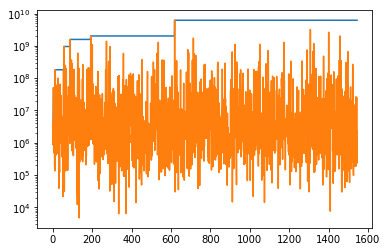

In [35]:
v = []
for i, res in enumerate(optimizer3.res):
    v.append(res['target'])
    
vn = []
for i, val in enumerate(v):
    mv = max(v[0:i+1])
    vn.append(mv)
    
plt.figure()
plt.plot(vn)
plt.plot(v)
plt.yscale('log')
plt.show()

In [39]:
df = pd.DataFrame({
    'CFV': v})
df.to_csv('CFV_Iter_4S_MultiplicativeNU05EI.csv')

df = pd.DataFrame({
    'CFV': vn})
df.to_csv('bestCFV_Iter_4S_MultiplicativeNU05EI.csv')

### Check results with plot

In [27]:
inputs = [round(optimizer3.max['params']['IPTG1'], 2)+1e-7, int(optimizer3.max['params']['aTc1'])+1e-7, 
          round(optimizer3.max['params']['IPTG2'], 2)+1e-7, int(optimizer3.max['params']['aTc2'])+1e-7]

ivss = [1,1e-7,1363.193,28.510]
pre = [1,1e-7]
sp = [int(i) for i in list(np.linspace(0,(24*60),3))]
t =  np.linspace(0,(24*60),(24*60)+1)

pM1 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model1.stan.csv"))
pM2 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model2.stan.csv"))

# Simulation of the system for the two models and extract of results
solM1 = solveALL(t, pM1, sp, inputs, ivss, pre, 'M1')
solM2 = solveALL(t, pM2, sp, inputs, ivss, pre, 'M2')

RFP_M1 = solM1[:,0:len(pM1[:,1])]
GFP_M1 = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]

RFP_M2 = solM2[:,0:len(pM2[:,1])]
GFP_M2 = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]


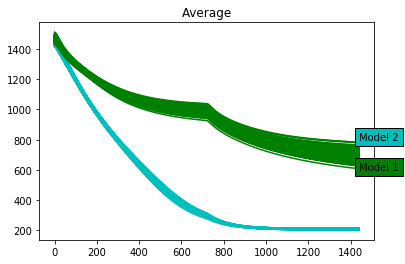

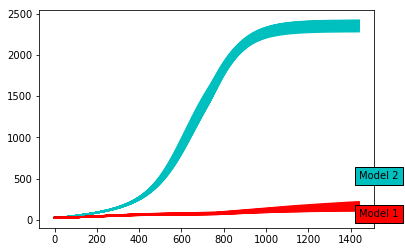

In [28]:
t = np.linspace(0,(24*60),round(24*60/5)+1)

plt.figure()
lines = plt.plot(t, GFP_M2, 'c')
plt.text((24*60)+1, 800, "Model 2", bbox=dict(facecolor='c'))
plt.title("Average")
lines2 = plt.plot(t, GFP_M1, 'g')
plt.text((24*60)+1, 600, "Model 1", bbox=dict(facecolor='g'))

plt.show()
plt.figure()
plt.plot(t, RFP_M2, 'c')

plt.text((24*60)+1, 500, "Model 2", bbox=dict(facecolor='c'))
plt.text((24*60)+1, 40, "Model 1", bbox=dict(facecolor='r'))
plt.plot(t, RFP_M1, 'r')
plt.show()

### Check utility decomposition results

In [ ]:
# Gaussian Process Regression and Reduction

# Means and standard deviations for each time point for each species and for each model
tgp = np.linspace(0,(24*60),(24*60/5)+1)

muR3 = RFP_M2.mean(axis = 1) # Model 2, RFP
sdR3 = RFP_M2.std(axis = 1)
muG3 = GFP_M2.mean(axis = 1) # Model 2, GFP
sdG3 = GFP_M2.std(axis = 1)
muR2 = RFP_M1.mean(axis = 1) # Model 1, RFP
sdR2 = RFP_M1.std(axis = 1)
muG2 = GFP_M1.mean(axis = 1) # Model 1, GFP
sdG2 = GFP_M1.std(axis = 1)

# Gaussian Process regression
gR3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR3, (sdR3**2)) # RFP, Model 2
gR3.findhyperparameters(noruns=15)
gR3.predict(tgp)

gG3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG3, (sdG3**2)) # GFP, Model 2
gG3.findhyperparameters(noruns=15)
gG3.predict(tgp)

gR2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR2, (sdR2**2)) # RFP, Model 1
gR2.findhyperparameters(noruns=15)
gR2.predict(tgp)

gG2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG2, (sdG2**2)) # GFP, Model 1
gG2.findhyperparameters(noruns=15)
gG2.predict(tgp)



In [ ]:
muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::10])
tref = list(tgp[::10])

g2R3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2R3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2R3.predict(tref)

muref = list(np.matrix.transpose((np.random.multivariate_normal(gR2.mnp, gR2.covp, 2000)))[::10])
tref = list(tgp[::10])

g2R2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2R2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2R2.predict(tref)

muref = list(np.matrix.transpose((np.random.multivariate_normal(gG3.mnp, gG3.covp, 2000)))[::10])
tref = list(tgp[::10])

g2G3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2G3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2G3.predict(tref)

muref = list(np.matrix.transpose((np.random.multivariate_normal(gG2.mnp, gG2.covp, 2000)))[::10])
tref = list(tgp[::10])

g2G2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2G2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2G2.predict(tref)

In [ ]:
bdR = BhattacharyyaDist(g2R3.mnp, g2R2.mnp, g2R3.covp, g2R2.covp)
bdG = BhattacharyyaDist(g2G3.mnp, g2G2.mnp, g2G3.covp, g2G2.covp)
u_B = (bdR*bdG)

In [ ]:
print("The BD for RFP is: ", str(bdR))
print("The BD for GFP is: ", str(bdG))
print("The multiplicative BD is: ", str(u_B))